In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from utils import *
from datetime import datetime

In [2]:
raw_df = pd.read_csv('data/FCC_reported_calls.csv')

In [3]:
# Drop unused columns
fcc_df = raw_df.drop(columns=['Form','Advertiser Business Number'])

# Create a single date+time column
fcc_df['DateTime'] = fcc_df[['Date of Issue','Time of Issue']].apply(lambda row: parse_date(row.values[0],row.values[1]), axis=1)
# fcc_df.drop(columns=['Date of Issue','Time of Issue'],inplace=True)

# Split up DateTime column
month, day, year, hour, minute = zip(*[(None, None, None, None, None) if dt is None else (dt.month, dt.day, dt.year, dt.hour, dt.minute) for dt in fcc_df['DateTime']])
fcc_df = fcc_df.assign(Month = month, Day = day, Year = year, Hour = hour, Minute = minute)

# Simply string entries for Method and Issue
fcc_df['Method'] = fcc_df['Method'].apply(func=remove_parenthesis)
fcc_df['Issue'] = fcc_df['Issue'].apply(func=remove_parenthesis)

# Remove rows with zip code 00000
fcc_df.drop(fcc_df[fcc_df['Zip'] == '00000'].index, inplace = True) 
fcc_df.drop(fcc_df[(fcc_df['Year'] > 2020) | ((fcc_df['Year'] == 2020) & (fcc_df['Month'] > 11))].index, inplace = True) 
fcc_df.drop(fcc_df[(fcc_df['Year'] < 2014) | ((fcc_df['Year'] == 2014) & (fcc_df['Month'] < 11))].index, inplace = True) # Data collection began October 30th

In [4]:
fcc_df.head()

,Ticket ID,Date of Issue,Time of Issue,Method,Issue,Caller ID Number,Type of Call or Messge,State,Zip,Location (Center point of the Zip Code),DateTime,Month,Day,Year,Hour,Minute
0,100358,01/26/2015,8:35 am,Wireless,Telemarketing,617-681-5500,Prerecorded Voice,WA,98115,"WA 98115\n(47.685291, -122.297534)",2015-01-26 20:35:00,1,26,2015,20,35
1,157640,03/02/2015,2:16 p.m.,Wired,Telemarketing,NaN,Prerecorded Voice,CO,80138,"CO 80138\n(39.518092, -104.688882)",2015-03-02 14:16:00,3,2,2015,14,16
2,104244,01/28/2015,11:00 AM,Wireless,Robocalls,415-964-2785,Prerecorded Voice,FL,33139,"FL 33139\n(25.783695, -80.141739)",2015-01-28 23:00:00,1,28,2015,23,0
3,153519,02/27/2015,11:31 AM,Wired,Robocalls,404-381-1115,Prerecorded Voice,VA,22182,"VA 22182\n(38.932908, -77.267432)",2015-02-27 23:31:00,2,27,2015,23,31
4,145971,02/23/2015,3:24 P.M.,Wireless,Telemarketing,203-204-2992,Live Voice,PA,17403,"PA 17403\n(39.935487, -76.710483)",2015-02-23 15:24:00,2,23,2015,15,24


#### h

In [5]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
rnn_df = fcc_df.copy()
rnn_df = rnn_df.dropna()
rnn_df['Day'] = rnn_df['Day'].apply(lambda x: x if int(x)>=10 else ('0'+str(x)))
rnn_df['Month_Name'] = rnn_df['Month'].apply(lambda x: months[x-1])
rnn_df['Month'] = rnn_df['Month'].apply(lambda x: x if int(x)>=10 else ('0'+str(x)))
rnn_df['Date'] =  rnn_df['Year'].astype(str) + rnn_df['Month'].astype(str) + rnn_df['Day'].astype(str)
rnn_df['Year'] = rnn_df['Year'].apply(lambda x: str(x)[-2:])
rnn_df['Date_Styled'] =  rnn_df['Month_Name'] + '-' + rnn_df['Day'].astype(str) + '-' + rnn_df['Year'].astype(str)
rnn_df.sort_values(by=['Date'],inplace=True)
rnn_df = rnn_df.groupby(['Date','State']).count()['Ticket ID']
idx = pd.IndexSlice
one_state_df = rnn_df.loc[idx[:,'NY']]
one_state_df = one_state_df.to_frame()

In [6]:
one_state_df

,Ticket ID
Date,
20141101,3
20141102,2
20141103,8
20141104,4
20141105,1
...,...
20201103,16
20201104,15
20201105,19


In [7]:
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(X.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
RANDOM_SEED = 100

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
test_percent = .2

In [10]:
train = one_state_df.iloc[:int(len(one_state_df)*(1-test_percent))] 
test = one_state_df.iloc[int(len(one_state_df)*(1-test_percent)):] 

In [11]:
X_train, y_train = create_dataset(train,5)
X_test, y_test = create_dataset(test,5)

### Parameter picking

#### Picking number of units for layers

In [12]:
scores = [[],[]]

tscv = TimeSeriesSplit(max_train_size=None, n_splits=10)

for n in range(0,250,50):
    temp_scores = []
    # Stacking cross val
    for train_index, test_index in tscv.split(X_train):
        X_train_tscv, X_test_tscv = X_train[train_index], X_train[test_index]
        y_train_tscv, y_test_tscv = y_train[train_index], y_train[test_index]

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.SimpleRNN(
          units=n,
          input_shape=(X_train_tscv.shape[1], X_train_tscv.shape[2])
        ))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
          loss='mean_squared_error',
          optimizer=tf.keras.optimizers.Adam(0.001)
        )

        model.fit(
            X_train_tscv, y_train_tscv,
            epochs=30,
            batch_size=16,
            validation_split=0.1,
            shuffle=False
        )
        
        temp_scores.append(model.evaluate(X_test_tscv, y_test_tscv))
    scores[0].append(n)   
    scores[1].append(np.average(temp_scores))

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/9 [==>...........................] - ETA: 0s - loss: 19.7500WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C93B7D0288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 14/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 15/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 16/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 17/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 18/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 19/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 20/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 21/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - val_loss: 641.5000
Epoch 22/30
17/17 [==============================] - 0s 2ms/step - loss: 358.9504 - v

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
33/33 [==============================] - 0s 6ms/step - loss: 458.5981 - val_loss: 449.0690
Epoch 2/30
33/33 [==============================] - 0s 1ms/step - loss: 458.5981 - val_loss: 449.0690
Epoch 3/30
33/33 [==============================] - 0s 1ms/step - loss: 458.5981 - val_loss: 449.0690
Epoch 4/30
33/33 [==============================] - 0s 1ms/step - loss: 458.5981 - val_loss: 449.0690
Epoch 5/30
33/33 [==============================] - 0s 1ms/step - loss: 458.5981 - val_loss: 449.0690
Epoch 6/30
33/33 [==============================] - 0s 1ms/step - loss: 458.5981 - val_loss: 449.0690
Epoch 7/30
33/33 [==============================] - 0s 1ms/step - loss: 458.5981 - val_l

41/41 [==============================] - 0s 1ms/step - loss: 461.5232 - val_loss: 262.3288
Epoch 26/30
41/41 [==============================] - 0s 1ms/step - loss: 461.5232 - val_loss: 262.3288
Epoch 27/30
41/41 [==============================] - 0s 1ms/step - loss: 461.5232 - val_loss: 262.3288
Epoch 28/30
41/41 [==============================] - 0s 1ms/step - loss: 461.5232 - val_loss: 262.3288
Epoch 29/30
41/41 [==============================] - 0s 1ms/step - loss: 461.5232 - val_loss: 262.3288
Epoch 30/30
5/5 [==============================] - 0s 598us/step - loss: 999.4545
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on L

57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 7/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 8/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 9/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 10/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 11/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 12/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 13/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 14/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_loss: 634.7822
Epoch 15/30
57/57 [==============================] - 0s 1ms/step - loss: 545.9216 - val_

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
42/73 [================>.............] - ETA: 0s - loss: 463.6592WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C93B6DD168> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 18/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 19/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 20/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 21/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 22/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 23/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 24/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 25/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - val_loss: 491.1180
Epoch 26/30
81/81 [==============================] - 0s 1ms/step - loss: 615.3777 - v

17/17 [==============================] - 0s 10ms/step - loss: 328.5915 - val_loss: 564.1807
Epoch 2/30
17/17 [==============================] - 0s 2ms/step - loss: 280.1783 - val_loss: 494.8654
Epoch 3/30
17/17 [==============================] - 0s 2ms/step - loss: 242.1161 - val_loss: 444.7471
Epoch 4/30
17/17 [==============================] - 0s 2ms/step - loss: 221.0719 - val_loss: 416.3269
Epoch 5/30
17/17 [==============================] - 0s 2ms/step - loss: 206.7756 - val_loss: 393.7729
Epoch 6/30
17/17 [==============================] - 0s 2ms/step - loss: 194.5750 - val_loss: 373.5679
Epoch 7/30
17/17 [==============================] - 0s 2ms/step - loss: 182.9971 - val_loss: 353.6730
Epoch 8/30
17/17 [==============================] - 0s 2ms/step - loss: 172.1496 - val_loss: 335.2344
Epoch 9/30
17/17 [==============================] - 0s 2ms/step - loss: 163.3307 - val_loss: 319.4505
Epoch 10/30
17/17 [==============================] - 0s 2ms/step - loss: 155.3668 - val_loss

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/33 [..............................] - ETA: 0s - loss: 20.9505WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C949D5F948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
C

41/41 [==============================] - 0s 2ms/step - loss: 112.1729 - val_loss: 113.2160
Epoch 16/30
41/41 [==============================] - 0s 1ms/step - loss: 109.5758 - val_loss: 108.7469
Epoch 17/30
41/41 [==============================] - 0s 2ms/step - loss: 105.0503 - val_loss: 103.5268
Epoch 18/30
41/41 [==============================] - 0s 2ms/step - loss: 100.6058 - val_loss: 100.0304
Epoch 19/30
41/41 [==============================] - 0s 2ms/step - loss: 97.2446 - val_loss: 94.9193
Epoch 20/30
41/41 [==============================] - 0s 2ms/step - loss: 94.0784 - val_loss: 89.4608
Epoch 21/30
41/41 [==============================] - 0s 2ms/step - loss: 91.0661 - val_loss: 84.3743
Epoch 22/30
41/41 [==============================] - 0s 2ms/step - loss: 88.3075 - val_loss: 78.6864
Epoch 23/30
41/41 [==============================] - 0s 2ms/step - loss: 86.0132 - val_loss: 74.4593
Epoch 24/30
41/41 [==============================] - 0s 1ms/step - loss: 84.1317 - val_loss: 71

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
57/57 [==============================] - 0s 4ms/step - loss: 407.8542 - val_loss: 397.5061
Epoch 2/30
57/57 [==============================] - 0s 2ms/step - loss: 303.6605 - val_loss: 312.7102
Epoch 3/30
57/57 [==============================] - 0s 1ms/step - loss: 252.4558 - val_loss: 259.6833
Epoch 4/30
57/57 [==============================] - 0s 2ms/step - loss: 221.6541 - val_loss: 227.9399
Epoch 5/30
57/57 [==============================] - 0s 1ms/step - loss: 200.2936 - val_loss: 206.0189
Epoch 6/30
57/57 [==============================] - 0s 2ms/step - loss: 183.0175 - val_loss: 186.5549
Epoch 7/30
57/57 [==============================] - 0s 2ms/step - loss: 170.9593 - val_l

65/65 [==============================] - 0s 2ms/step - loss: 89.8179 - val_loss: 227.6191
Epoch 28/30
65/65 [==============================] - 0s 1ms/step - loss: 87.7072 - val_loss: 222.7763
Epoch 29/30
65/65 [==============================] - 0s 2ms/step - loss: 85.7949 - val_loss: 218.2760
Epoch 30/30
5/5 [==============================] - 0s 998us/step - loss: 62.6191
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_

81/81 [==============================] - 0s 1ms/step - loss: 171.7581 - val_loss: 140.7824
Epoch 9/30
81/81 [==============================] - 0s 1ms/step - loss: 160.8057 - val_loss: 128.4441
Epoch 10/30
81/81 [==============================] - 0s 1ms/step - loss: 151.0244 - val_loss: 132.5505
Epoch 11/30
81/81 [==============================] - 0s 1ms/step - loss: 147.5485 - val_loss: 119.6210
Epoch 12/30
81/81 [==============================] - 0s 1ms/step - loss: 141.3564 - val_loss: 121.1527
Epoch 13/30
81/81 [==============================] - 0s 1ms/step - loss: 138.5884 - val_loss: 113.9787
Epoch 14/30
81/81 [==============================] - 0s 1ms/step - loss: 135.5260 - val_loss: 113.4510
Epoch 15/30
81/81 [==============================] - 0s 1ms/step - loss: 131.2996 - val_loss: 108.8793
Epoch 16/30
81/81 [==============================] - 0s 1ms/step - loss: 124.8804 - val_loss: 105.7422
Epoch 17/30
81/81 [==============================] - 0s 1ms/step - loss: 119.5788 - va

 1/17 [>.............................] - ETA: 0s - loss: 19.6026WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C93B7A3CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 0s 11ms/step - loss: 298.7505 - val_loss: 474.6577
Epoch 2/30
17/17 [==============================] - 0s 3ms/step - los

Epoch 21/30
25/25 [==============================] - 0s 2ms/step - loss: 71.7212 - val_loss: 72.3515
Epoch 22/30
25/25 [==============================] - 0s 2ms/step - loss: 70.2325 - val_loss: 70.8662
Epoch 23/30
25/25 [==============================] - 0s 2ms/step - loss: 68.6255 - val_loss: 68.3748
Epoch 24/30
25/25 [==============================] - 0s 2ms/step - loss: 67.0684 - val_loss: 67.9458
Epoch 25/30
25/25 [==============================] - 0s 2ms/step - loss: 65.5796 - val_loss: 66.3249
Epoch 26/30
25/25 [==============================] - 0s 2ms/step - loss: 63.7139 - val_loss: 65.7126
Epoch 27/30
25/25 [==============================] - 0s 2ms/step - loss: 62.1087 - val_loss: 64.8550
Epoch 28/30
25/25 [==============================] - 0s 2ms/step - loss: 60.8291 - val_loss: 64.2574
Epoch 29/30
25/25 [==============================] - 0s 2ms/step - loss: 59.4170 - val_loss: 63.6963
Epoch 30/30
5/5 [==============================] - 0s 996us/step - loss: 64.4286
Epoch 1/30

41/41 [==============================] - 0s 6ms/step - loss: 334.2046 - val_loss: 138.5874
Epoch 2/30
41/41 [==============================] - 0s 2ms/step - loss: 183.6330 - val_loss: 120.2117
Epoch 3/30
41/41 [==============================] - 0s 2ms/step - loss: 147.5387 - val_loss: 124.0585
Epoch 4/30
41/41 [==============================] - 0s 2ms/step - loss: 132.6849 - val_loss: 130.3133
Epoch 5/30
41/41 [==============================] - 0s 2ms/step - loss: 125.9688 - val_loss: 135.5526
Epoch 6/30
41/41 [==============================] - 0s 2ms/step - loss: 122.7811 - val_loss: 139.0471
Epoch 7/30
41/41 [==============================] - 0s 2ms/step - loss: 120.8544 - val_loss: 135.8036
Epoch 8/30
41/41 [==============================] - 0s 2ms/step - loss: 116.9344 - val_loss: 124.2430
Epoch 9/30
41/41 [==============================] - 0s 2ms/step - loss: 110.8251 - val_loss: 120.5170
Epoch 10/30
41/41 [==============================] - 0s 2ms/step - loss: 105.7267 - val_loss:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
31/57 [===============>..............] - ETA: 0s - loss: 326.4739WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C93A959798> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


65/65 [==============================] - 0s 2ms/step - loss: 84.6412 - val_loss: 204.7390
Epoch 19/30
65/65 [==============================] - 0s 2ms/step - loss: 81.5515 - val_loss: 196.0992
Epoch 20/30
65/65 [==============================] - 0s 2ms/step - loss: 78.8614 - val_loss: 188.6905
Epoch 21/30
65/65 [==============================] - 0s 2ms/step - loss: 76.0533 - val_loss: 181.5402
Epoch 22/30
65/65 [==============================] - 0s 2ms/step - loss: 73.9370 - val_loss: 175.7733
Epoch 23/30
65/65 [==============================] - 0s 2ms/step - loss: 71.9870 - val_loss: 169.6672
Epoch 24/30
65/65 [==============================] - 0s 2ms/step - loss: 70.4187 - val_loss: 165.8197
Epoch 25/30
65/65 [==============================] - 0s 2ms/step - loss: 69.1779 - val_loss: 162.3092
Epoch 26/30
65/65 [==============================] - 0s 2ms/step - loss: 67.5684 - val_loss: 157.1181
Epoch 27/30
65/65 [==============================] - 0s 2ms/step - loss: 66.5437 - val_loss: 1

81/81 [==============================] - 0s 4ms/step - loss: 327.0014 - val_loss: 189.6401
Epoch 2/30
81/81 [==============================] - 0s 2ms/step - loss: 208.3076 - val_loss: 173.3322
Epoch 3/30
81/81 [==============================] - 0s 2ms/step - loss: 191.9618 - val_loss: 169.6834
Epoch 4/30
81/81 [==============================] - 0s 2ms/step - loss: 178.3096 - val_loss: 146.7807
Epoch 5/30
81/81 [==============================] - 0s 2ms/step - loss: 158.3631 - val_loss: 128.7109
Epoch 6/30
81/81 [==============================] - 0s 2ms/step - loss: 144.0968 - val_loss: 119.6954
Epoch 7/30
81/81 [==============================] - 0s 2ms/step - loss: 133.8212 - val_loss: 113.6323
Epoch 8/30
81/81 [==============================] - 0s 2ms/step - loss: 127.0392 - val_loss: 111.1602
Epoch 9/30
81/81 [==============================] - 0s 2ms/step - loss: 118.3935 - val_loss: 102.4932
Epoch 10/30
81/81 [==============================] - 0s 2ms/step - loss: 109.9595 - val_loss:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/17 [>.............................] - ETA: 0s - loss: 17.4195WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C93AFC9948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
C

25/25 [==============================] - 0s 2ms/step - loss: 69.3489 - val_loss: 72.4953
Epoch 19/30
25/25 [==============================] - 0s 2ms/step - loss: 67.3491 - val_loss: 70.6277
Epoch 20/30
25/25 [==============================] - 0s 2ms/step - loss: 65.4035 - val_loss: 69.2746
Epoch 21/30
25/25 [==============================] - 0s 2ms/step - loss: 63.4853 - val_loss: 67.6833
Epoch 22/30
25/25 [==============================] - 0s 2ms/step - loss: 61.5971 - val_loss: 66.1764
Epoch 23/30
25/25 [==============================] - 0s 2ms/step - loss: 59.4951 - val_loss: 65.5422
Epoch 24/30
25/25 [==============================] - 0s 2ms/step - loss: 57.8026 - val_loss: 65.6927
Epoch 25/30
25/25 [==============================] - 0s 2ms/step - loss: 56.1017 - val_loss: 65.6011
Epoch 26/30
25/25 [==============================] - 0s 2ms/step - loss: 53.9040 - val_loss: 65.6186
Epoch 27/30
25/25 [==============================] - 0s 2ms/step - loss: 51.6774 - val_loss: 63.3714
Ep

41/41 [==============================] - 0s 6ms/step - loss: 226.1958 - val_loss: 128.6079
Epoch 2/30
41/41 [==============================] - 0s 2ms/step - loss: 135.0086 - val_loss: 134.3068
Epoch 3/30
41/41 [==============================] - 0s 2ms/step - loss: 122.6082 - val_loss: 136.4273
Epoch 4/30
41/41 [==============================] - 0s 2ms/step - loss: 117.6824 - val_loss: 135.0111
Epoch 5/30
41/41 [==============================] - 0s 2ms/step - loss: 113.1607 - val_loss: 117.4588
Epoch 6/30
41/41 [==============================] - 0s 2ms/step - loss: 105.1352 - val_loss: 110.9923
Epoch 7/30
41/41 [==============================] - 0s 2ms/step - loss: 98.7919 - val_loss: 107.0823
Epoch 8/30
41/41 [==============================] - 0s 2ms/step - loss: 92.5355 - val_loss: 95.9111
Epoch 9/30
41/41 [==============================] - 0s 2ms/step - loss: 87.3781 - val_loss: 80.4559
Epoch 10/30
41/41 [==============================] - 0s 2ms/step - loss: 82.2910 - val_loss: 72.81

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
31/57 [===============>..............] - ETA: 0s - loss: 253.3615WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C9490065E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


65/65 [==============================] - 0s 2ms/step - loss: 69.6341 - val_loss: 161.5945
Epoch 19/30
65/65 [==============================] - 0s 2ms/step - loss: 67.2422 - val_loss: 153.8830
Epoch 20/30
65/65 [==============================] - 0s 2ms/step - loss: 66.1726 - val_loss: 152.4637
Epoch 21/30
65/65 [==============================] - 0s 2ms/step - loss: 64.0004 - val_loss: 147.3128
Epoch 22/30
65/65 [==============================] - 0s 2ms/step - loss: 63.0332 - val_loss: 145.1341
Epoch 23/30
65/65 [==============================] - 0s 2ms/step - loss: 61.6886 - val_loss: 141.6117
Epoch 24/30
65/65 [==============================] - 0s 2ms/step - loss: 60.8136 - val_loss: 139.1218
Epoch 25/30
65/65 [==============================] - 0s 2ms/step - loss: 59.7869 - val_loss: 137.1118
Epoch 26/30
65/65 [==============================] - 0s 2ms/step - loss: 58.7876 - val_loss: 135.8216
Epoch 27/30
65/65 [==============================] - 0s 2ms/step - loss: 57.8396 - val_loss: 1

81/81 [==============================] - 0s 4ms/step - loss: 258.2831 - val_loss: 169.9436
Epoch 2/30
81/81 [==============================] - 0s 2ms/step - loss: 180.8884 - val_loss: 152.3333
Epoch 3/30
81/81 [==============================] - 0s 2ms/step - loss: 155.5376 - val_loss: 124.5287
Epoch 4/30
81/81 [==============================] - 0s 2ms/step - loss: 136.7192 - val_loss: 113.5868
Epoch 5/30
81/81 [==============================] - 0s 2ms/step - loss: 123.6287 - val_loss: 104.5357
Epoch 6/30
81/81 [==============================] - 0s 2ms/step - loss: 111.8724 - val_loss: 95.9834
Epoch 7/30
81/81 [==============================] - 0s 2ms/step - loss: 101.3266 - val_loss: 88.4059
Epoch 8/30
81/81 [==============================] - 0s 2ms/step - loss: 94.3499 - val_loss: 88.0985
Epoch 9/30
81/81 [==============================] - 0s 2ms/step - loss: 89.4739 - val_loss: 90.2923
Epoch 10/30
81/81 [==============================] - 0s 2ms/step - loss: 86.3878 - val_loss: 91.052

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/17 [>.............................] - ETA: 0s - loss: 31.7380WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C94A27AA68> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
C

25/25 [==============================] - 0s 3ms/step - loss: 65.0041 - val_loss: 67.1447
Epoch 19/30
25/25 [==============================] - 0s 3ms/step - loss: 64.0112 - val_loss: 67.4933
Epoch 20/30
25/25 [==============================] - 0s 2ms/step - loss: 61.9831 - val_loss: 65.7596
Epoch 21/30
25/25 [==============================] - 0s 3ms/step - loss: 60.9351 - val_loss: 65.9237
Epoch 22/30
25/25 [==============================] - 0s 2ms/step - loss: 59.6775 - val_loss: 64.9380
Epoch 23/30
25/25 [==============================] - 0s 2ms/step - loss: 58.7439 - val_loss: 64.5408
Epoch 24/30
25/25 [==============================] - 0s 2ms/step - loss: 57.7931 - val_loss: 63.5357
Epoch 25/30
25/25 [==============================] - 0s 2ms/step - loss: 56.7337 - val_loss: 63.6539
Epoch 26/30
25/25 [==============================] - 0s 2ms/step - loss: 56.1987 - val_loss: 61.9434
Epoch 27/30
25/25 [==============================] - 0s 2ms/step - loss: 54.0147 - val_loss: 62.6269
Ep

41/41 [==============================] - 0s 6ms/step - loss: 163.0038 - val_loss: 132.2087
Epoch 2/30
41/41 [==============================] - 0s 2ms/step - loss: 115.7284 - val_loss: 131.8104
Epoch 3/30
41/41 [==============================] - 0s 2ms/step - loss: 108.8894 - val_loss: 118.3538
Epoch 4/30
41/41 [==============================] - 0s 2ms/step - loss: 102.4260 - val_loss: 112.3700
Epoch 5/30
41/41 [==============================] - 0s 2ms/step - loss: 96.1658 - val_loss: 97.7170
Epoch 6/30
41/41 [==============================] - 0s 2ms/step - loss: 89.9061 - val_loss: 87.6629
Epoch 7/30
41/41 [==============================] - 0s 2ms/step - loss: 85.3819 - val_loss: 73.3975
Epoch 8/30
41/41 [==============================] - 0s 2ms/step - loss: 80.3869 - val_loss: 67.3758
Epoch 9/30
41/41 [==============================] - 0s 2ms/step - loss: 75.4900 - val_loss: 60.1270
Epoch 10/30
41/41 [==============================] - 0s 2ms/step - loss: 70.1898 - val_loss: 57.6099
Ep

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/57 [==========================>...] - ETA: 0s - loss: 208.5724WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C93AB5E288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


65/65 [==============================] - 0s 2ms/step - loss: 70.2512 - val_loss: 156.2179
Epoch 19/30
65/65 [==============================] - 0s 2ms/step - loss: 69.7849 - val_loss: 155.4099
Epoch 20/30
65/65 [==============================] - 0s 2ms/step - loss: 67.7150 - val_loss: 148.0689
Epoch 21/30
65/65 [==============================] - 0s 2ms/step - loss: 66.9788 - val_loss: 149.5264
Epoch 22/30
65/65 [==============================] - 0s 2ms/step - loss: 65.7803 - val_loss: 143.1082
Epoch 23/30
65/65 [==============================] - 0s 2ms/step - loss: 64.4542 - val_loss: 143.6817
Epoch 24/30
65/65 [==============================] - 0s 2ms/step - loss: 62.7659 - val_loss: 142.6537
Epoch 25/30
65/65 [==============================] - 0s 2ms/step - loss: 61.2178 - val_loss: 140.8110
Epoch 26/30
65/65 [==============================] - 0s 2ms/step - loss: 60.3569 - val_loss: 139.2077
Epoch 27/30
65/65 [==============================] - 0s 2ms/step - loss: 59.1768 - val_loss: 1

81/81 [==============================] - 0s 4ms/step - loss: 241.1425 - val_loss: 175.3714
Epoch 2/30
81/81 [==============================] - 0s 2ms/step - loss: 173.4116 - val_loss: 144.0845
Epoch 3/30
81/81 [==============================] - 0s 2ms/step - loss: 150.0703 - val_loss: 124.2640
Epoch 4/30
81/81 [==============================] - 0s 2ms/step - loss: 132.4323 - val_loss: 115.4693
Epoch 5/30
81/81 [==============================] - 0s 2ms/step - loss: 118.8321 - val_loss: 103.1281
Epoch 6/30
81/81 [==============================] - 0s 2ms/step - loss: 107.1169 - val_loss: 91.8459
Epoch 7/30
81/81 [==============================] - 0s 2ms/step - loss: 100.4654 - val_loss: 87.6659
Epoch 8/30
81/81 [==============================] - 0s 2ms/step - loss: 94.9068 - val_loss: 85.6109
Epoch 9/30
81/81 [==============================] - 0s 2ms/step - loss: 90.7633 - val_loss: 84.3470
Epoch 10/30
81/81 [==============================] - 0s 2ms/step - loss: 88.0204 - val_loss: 84.179

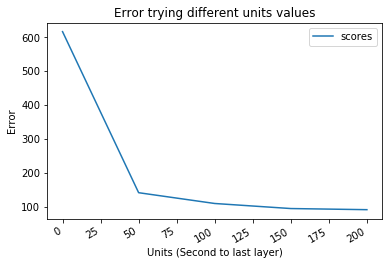

In [13]:
graph_df = pd.DataFrame()
graph_df['scores'] = scores[1]
graph_df.index = scores[0]
graph_df.plot(subplots=True)
plt.title('Error trying different units values')
plt.ylabel('Error')
plt.xlabel('Units (Second to last layer)')
plt.show()

#### Picking number of epochs

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(
  units=100,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(tf.keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
);

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    validation_split=0.1,
    shuffle=False
);

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/45 [===============>..............] - ETA: 0s - loss: 289.0261WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C949D473A8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

45/45 [==============================] - 0s 2ms/step - loss: 57.8464 - val_loss: 105.9930
Epoch 63/150
45/45 [==============================] - 0s 2ms/step - loss: 57.5166 - val_loss: 105.9529
Epoch 64/150
45/45 [==============================] - 0s 2ms/step - loss: 57.2089 - val_loss: 105.8962
Epoch 65/150
45/45 [==============================] - 0s 2ms/step - loss: 56.9185 - val_loss: 105.8382
Epoch 66/150
45/45 [==============================] - 0s 2ms/step - loss: 56.6408 - val_loss: 105.7815
Epoch 67/150
45/45 [==============================] - 0s 2ms/step - loss: 56.3709 - val_loss: 105.7236
Epoch 68/150
45/45 [==============================] - 0s 2ms/step - loss: 56.1052 - val_loss: 105.6639
Epoch 69/150
45/45 [==============================] - 0s 2ms/step - loss: 55.8418 - val_loss: 105.6067
Epoch 70/150
45/45 [==============================] - 0s 2ms/step - loss: 55.5791 - val_loss: 105.5621
Epoch 71/150
45/45 [==============================] - 0s 2ms/step - loss: 55.3178 - va

45/45 [==============================] - 0s 2ms/step - loss: 45.0354 - val_loss: 113.3546
Epoch 142/150
45/45 [==============================] - 0s 2ms/step - loss: 44.8597 - val_loss: 113.6265
Epoch 143/150
45/45 [==============================] - 0s 2ms/step - loss: 44.7348 - val_loss: 113.9667
Epoch 144/150
45/45 [==============================] - 0s 2ms/step - loss: 44.6377 - val_loss: 114.2800
Epoch 145/150
45/45 [==============================] - 0s 2ms/step - loss: 44.5411 - val_loss: 114.5407
Epoch 146/150
45/45 [==============================] - 0s 2ms/step - loss: 44.4329 - val_loss: 114.7644
Epoch 147/150
45/45 [==============================] - 0s 3ms/step - loss: 44.3127 - val_loss: 114.9634
Epoch 148/150
45/45 [==============================] - 0s 3ms/step - loss: 44.1851 - val_loss: 115.1336
Epoch 149/150
45/45 [==============================] - 0s 3ms/step - loss: 44.0548 - val_loss: 115.2683
Epoch 150/150
45/45 [==============================] - 0s 2ms/step - loss: 43.

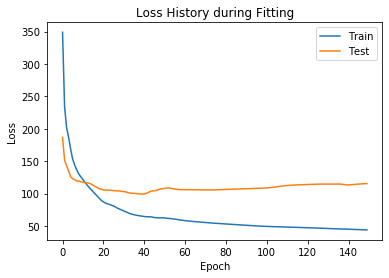

In [16]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title("Loss History during Fitting")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

### Final Model

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(
  units=100,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(tf.keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)

model.fit(
    X_train, y_train,
    epochs=60,
    validation_split=0.1,
    shuffle=False
);

Epoch 1/60
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/45 [==============>...............] - ETA: 0s - loss: 338.6275WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C93AE1A828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

In [18]:
y_pred = model.predict(X_test);

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [19]:
x_pred_graph = []
y_pred_graph = []
for arr in y_pred:
    y_pred_graph.append(arr[0])

In [20]:
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 5

In [21]:
def parse_date(date='20001212'):
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    date_styled =  months[int(date[4:6])-1] + '-' + str(date[6:8]) + '-' + str(date[2:4])
    return date_styled

In [22]:
x_ticks_train = [parse_date(x) for x in train.index]

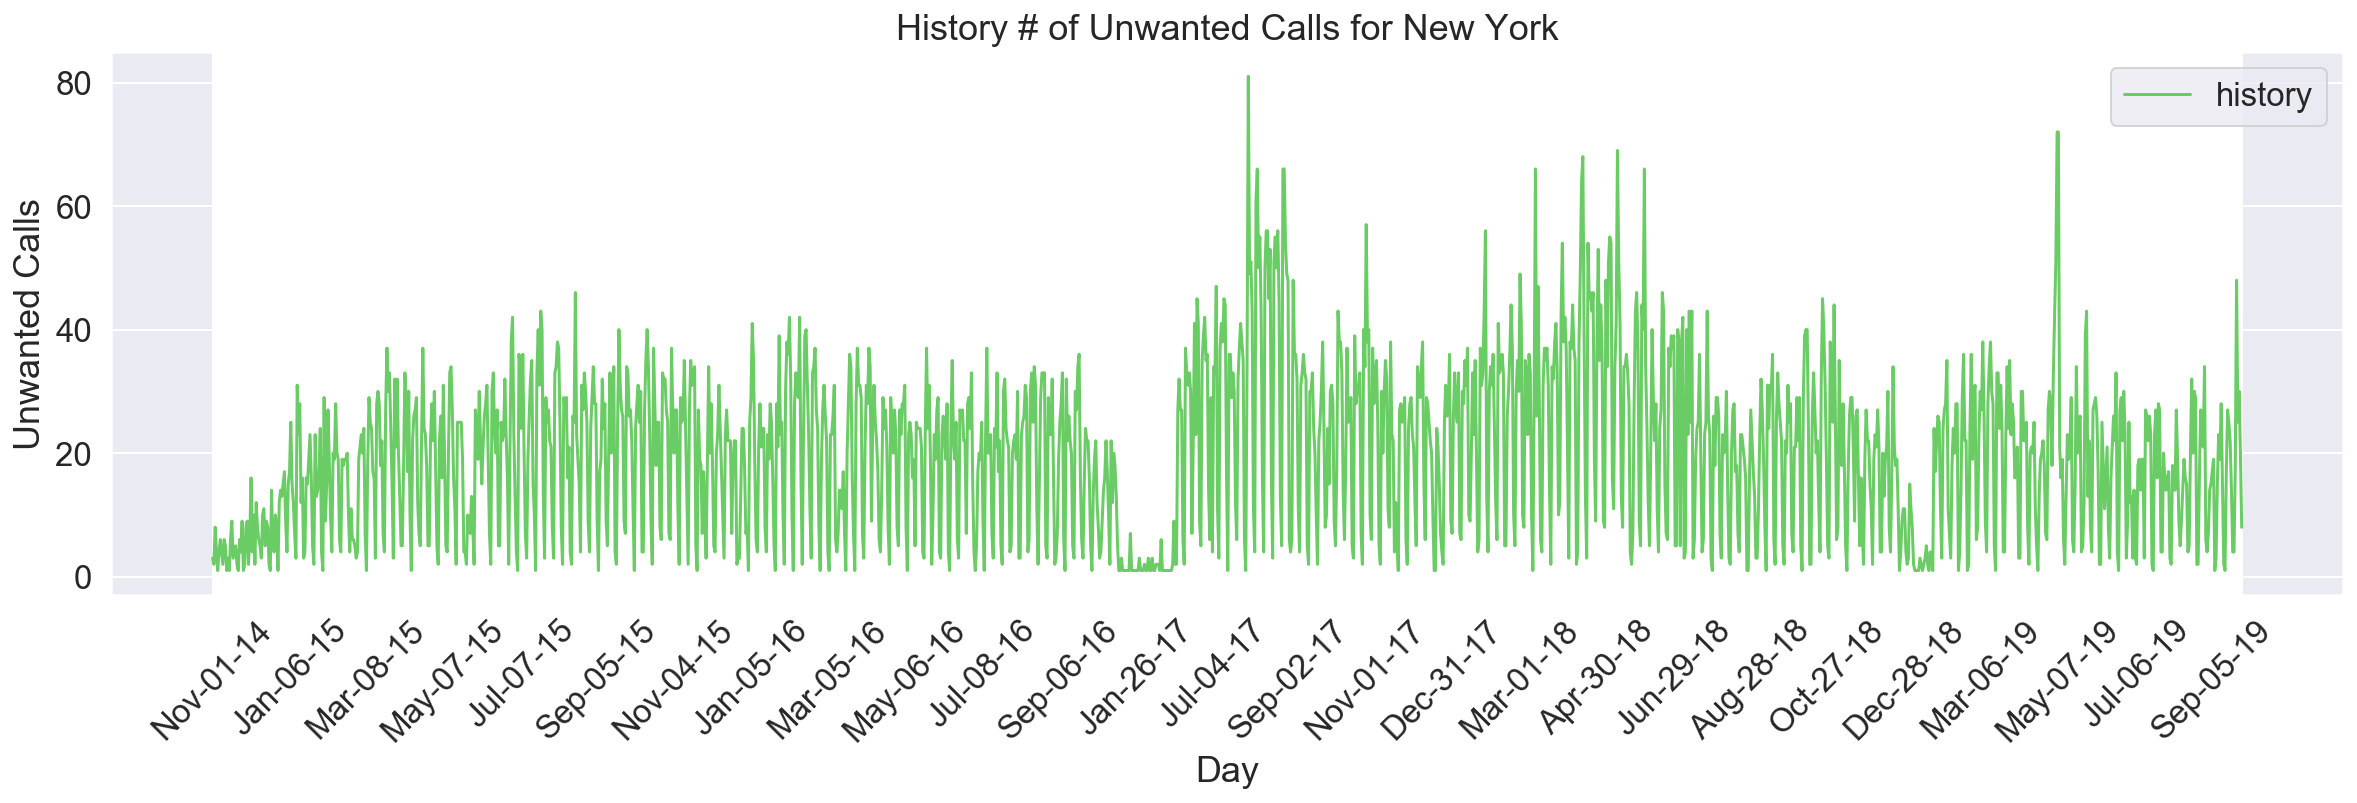

In [24]:
fig, ax = plt.subplots()
ax.set_title("History # of Unwanted Calls for "+ 'New York')
ax.plot(x_ticks_train, train, 'g', label="history")
ax.set_ylabel('Unwanted Calls')
ax.set_xlabel('Day')
every_nth = 60
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [25]:
x_ticks_test = [parse_date(x) for x in test.index]

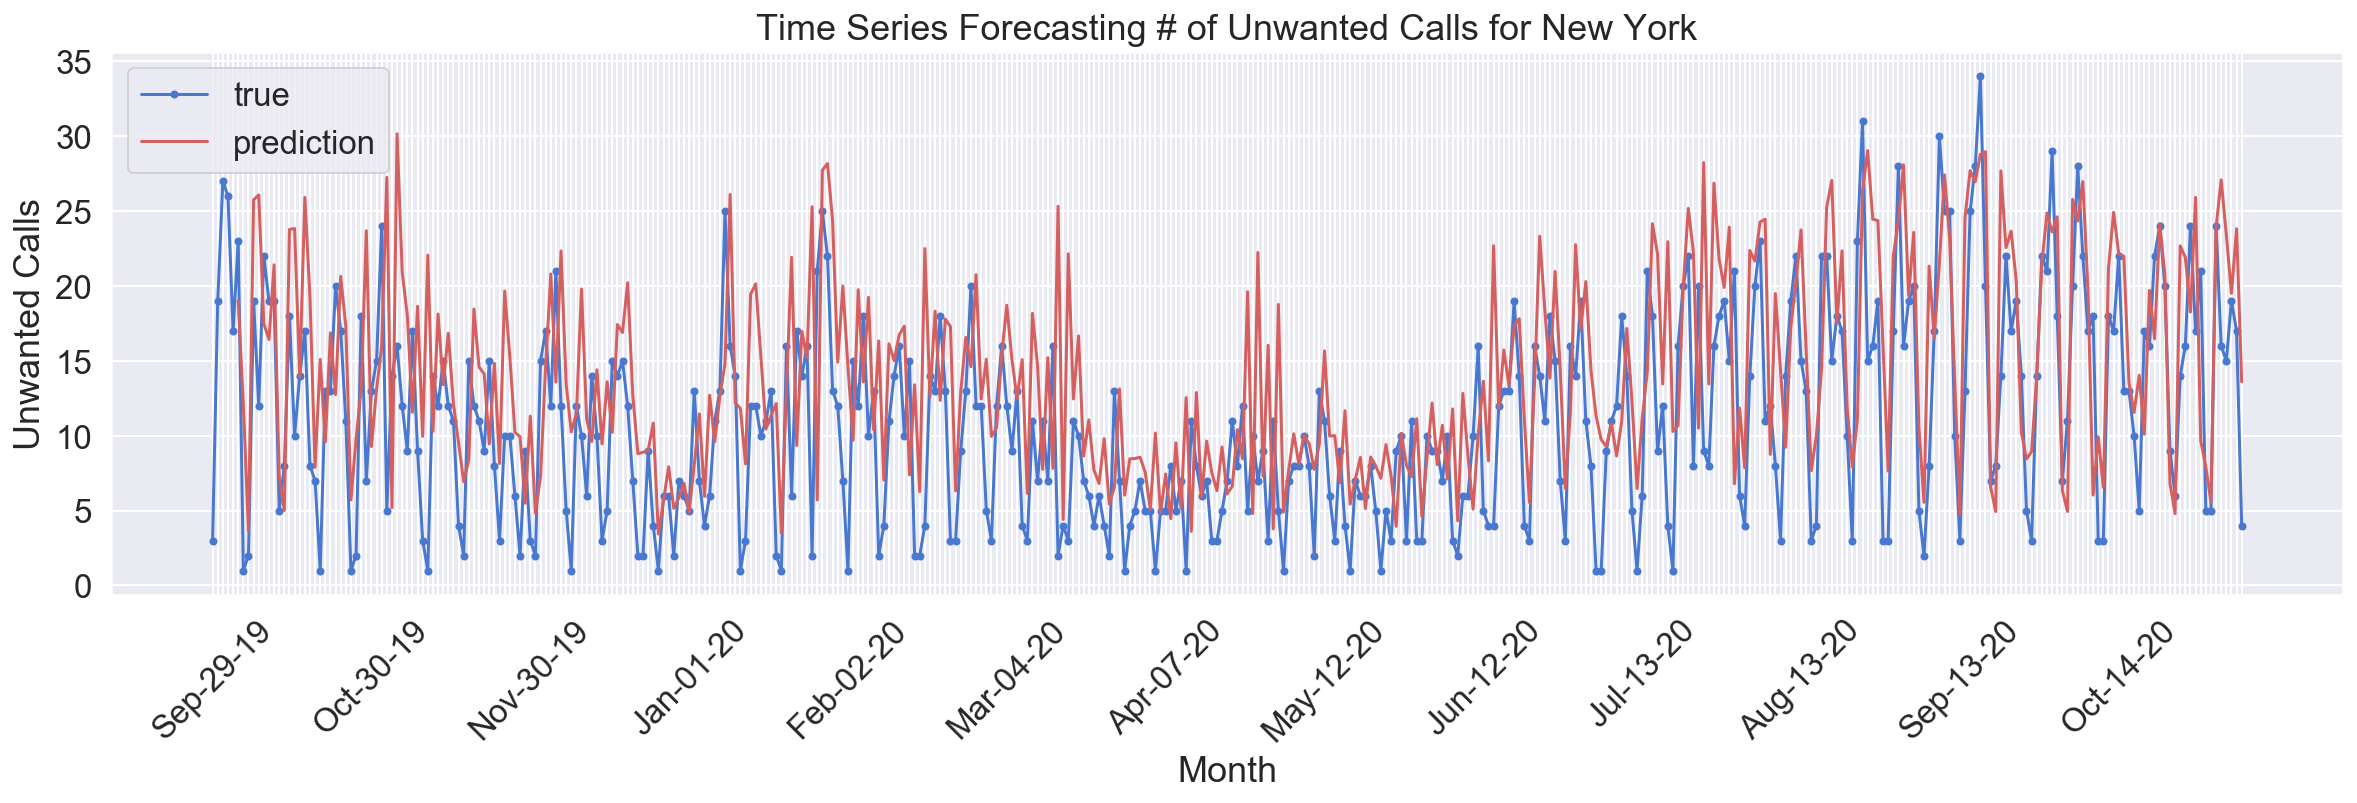

In [26]:
fig, ax = plt.subplots()
ax.set_title("Time Series Forecasting # of Unwanted Calls for "+ 'New York')
ax.plot(x_ticks_test, test, marker='.', label="true")
ax.plot(x_ticks_test[5:], y_pred_graph, 'r', label="prediction")
ax.set_ylabel('Unwanted Calls')
ax.set_xlabel('Month')

every_nth = 31
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.xticks(rotation=45)
plt.legend()
plt.show()